In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
gis = GIS()

In [2]:
#Load open listings from Redfin
housing_data = pd.read_csv('LA_County_Housing_2021-03-10.csv')

In [3]:
housing_data.head()

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Condo/Co-op,15057 Sherman Way Unit C,Van Nuys,CA,91405,509000,3.0,3.00,...,Active,NaN,NaN,http://www.redfin.com/CA/Van-Nuys/15057-Sherma...,CRMLS,BB21044163,N,Y,34.202122,-118.461117
1,MLS Listing,NaN,Condo/Co-op,4080 Via Marisol #135,Los Angeles,CA,90042,489000,2.0,1.00,...,Active,NaN,NaN,http://www.redfin.com/CA/Los-Angeles/4080-Via-...,CRMLS,BB21049055,N,Y,34.093379,-118.184183
2,MLS Listing,NaN,Townhouse,1620 237th St #9,Los Angeles,CA,90710,648000,4.0,3.00,...,Pre On-Market,NaN,NaN,http://www.redfin.com/CA/Harbor-City/1620-237t...,CRMLS,SB21033842,N,Y,33.810072,-118.307634
3,MLS Listing,NaN,Townhouse,14853 Hartsook St #104,Sherman Oaks,CA,91403,599000,3.0,2.75,...,Active,NaN,NaN,http://www.redfin.com/CA/Sherman-Oaks/14853-Ha...,CRMLS,BB21040455,N,Y,34.164218,-118.457078
4,MLS Listing,NaN,Condo/Co-op,11855 Goshen Ave #303,Los Angeles,CA,90049,1190000,2.0,3.00,...,Active,NaN,NaN,http://www.redfin.com/CA/Los-Angeles/11855-Gos...,CRMLS,PW21045752,N,Y,34.048126,-118.464884


In [4]:
housing_data.columns

Index(['SALE TYPE', 'SOLD DATE', 'PROPERTY TYPE', 'ADDRESS', 'CITY',
       'STATE OR PROVINCE', 'ZIP OR POSTAL CODE', 'PRICE', 'BEDS', 'BATHS',
       'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'DAYS ON MARKET',
       '$/SQUARE FEET', 'HOA/MONTH', 'STATUS', 'NEXT OPEN HOUSE START TIME',
       'NEXT OPEN HOUSE END TIME',
       'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
       'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [5]:
#Remove extraneous columns
housing_data.drop(columns=['SALE TYPE',
                          'SOLD DATE',
                          'STATUS', 
                          'NEXT OPEN HOUSE START TIME',
                          'NEXT OPEN HOUSE END TIME',
                          'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 
                          'SOURCE',
                          'MLS#', 
                          'FAVORITE',
                          'INTERESTED'], inplace=True)

In [6]:
#Rename columns
housing_data.rename(index=str, columns={'ZIP OR POSTAL CODE':'ZIP','$/SQUARE FEET':'PRICE PER SQFT',
                                       'HOA/MONTH':'HOA PER MONTH'}, inplace=True)
housing_data.columns

Index(['PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE OR PROVINCE', 'ZIP', 'PRICE',
       'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'DAYS ON MARKET', 'PRICE PER SQFT', 'HOA PER MONTH', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')

In [7]:
housing_data.shape

(350, 17)

In [8]:
#Remove rows with missing data
housing_data = housing_data.dropna(axis=0, how='any', 
                                        subset=['BEDS', 'BATHS', 'PRICE', 'YEAR BUILT', 'LATITUDE', 'LONGITUDE'])
housing_data.shape

(332, 17)

In [9]:
housing_data.describe()

,ZIP,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,PRICE PER SQFT,HOA PER MONTH,LATITUDE,LONGITUDE
count,332.000000,3.320000e+02,332.000000,332.000000,332.000000,321.000000,332.000000,332.000000,332.000000,129.000000,332.000000,332.000000
mean,90542.789157,1.483893e+06,3.545181,3.051205,2257.584337,32800.514019,1964.234940,5.301205,2376.542169,512.178295,34.085970,-118.386633
std,616.659330,1.751093e+06,3.108473,3.115600,2171.892433,78799.960746,32.211427,18.173541,31523.256905,420.107138,0.112168,0.110391
min,90002.000000,1.150000e+05,0.000000,1.000000,1.000000,1000.000000,1887.000000,1.000000,80.000000,2.000000,33.717634,-118.662620
25%,90036.000000,6.750000e+05,2.000000,2.000000,1240.000000,6006.000000,1939.000000,1.000000,449.750000,300.000000,34.037494,-118.462978
50%,90069.000000,9.345000e+05,3.000000,2.500000,1680.000000,7805.000000,1963.500000,1.000000,584.000000,425.000000,34.088473,-118.381919
75%,91316.000000,1.574750e+06,4.000000,3.250000,2437.750000,19499.000000,1989.000000,1.000000,744.750000,550.000000,34.161398,-118.301711
max,91607.000000,1.938000e+07,44.000000,42.000000,26763.000000,696031.000000,2021.000000,173.000000,575000.000000,2811.000000,34.327244,-118.133389


<AxesSubplot:title={'center':'Property Type Frequency'}>

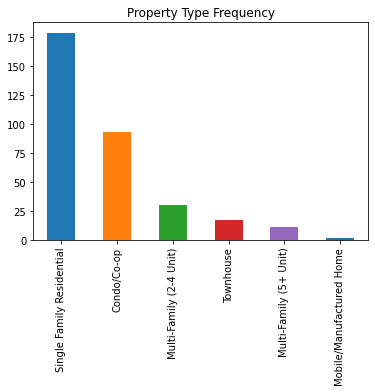

In [10]:
#Frequency plot of 'PROPERTY TYPE' column
housing_data['PROPERTY TYPE'].value_counts().plot(kind='bar', title='Property Type Frequency', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

In [11]:
#Convert DataFrame to Spatial DataFrame
housing_sdf = pd.DataFrame.spatial.from_xy(housing_data,'LONGITUDE','LATITUDE')

In [12]:
#Filter DataFrame to only show Single Family Residential listings
SFR_sdf = housing_sdf[(housing_sdf['PROPERTY TYPE']=='Single Family Residential')]

In [13]:
#plot listings on map of LA County
price_map = gis.map('Los Angeles, CA')
price_map.basemap = 'gray-vector'
price_map

MapView(layout=Layout(height='400px', width='100%'))

![](/map.png)

In [14]:
housing_sdf.spatial.plot(map_widget=price_map,
                        renderer_type='c',
                        method='esriClassifyQuantile',
                        class_count=10,
                        col='PRICE',
                        cmap='BuPu_r',
                        alpha=0.5,
                        outline_color=[50,0,0,50], line_width=1)

True

Text(0.5, 1.0, 'Price Histogram')

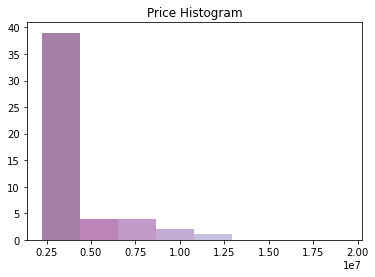

In [15]:
#Graph histogram of data, bar color corresponds to points on graph (lighter -> more expensive)
price_class_breaks = price_map.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
cbs_list = []
cmap_list = []
for cb in price_class_breaks:
    cbs_list.append(cb.classMaxValue)
    cmap_list.append([x/255.0 for x in cb.symbol.color])
    
n, bins, patches = plt.hist(housing_sdf['PRICE'], bins=cbs_list)

idx = 0
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cmap_list[idx])
    idx+=1
    
plt.title('Price Histogram')